# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

Answer: The data collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79,354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix




import time


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Check for missing values
missing_values = df.isnull().sum()

# Check data types and look for columns that may need type coercion
data_types = df.dtypes

print("Missing values in each column:\n", missing_values)
print("\nData types of each column:\n", data_types)

Missing values in each column:
 age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Data types of each column:
 age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [5]:
# Coerce the categorical features to type 'category'
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
df[categorical_features] = df[categorical_features].apply(lambda x: x.astype('category'))

# If you intend to build a realistic predictive model, drop 'duration'
df = df.drop('duration', axis=1)

# Encode binary output variable 'y' to numeric
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# One-hot encode the categorical variables
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Now all features should be numeric
print("\nData types after encoding:\n", df.dtypes)


Data types after encoding:
 age                                int64
campaign                           int64
pdays                              int64
previous                           int64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
y                                  int64
job_blue-collar                     bool
job_entrepreneur                    bool
job_housemaid                       bool
job_management                      bool
job_retired                         bool
job_self-employed                   bool
job_services                        bool
job_student                         bool
job_technician                      bool
job_unemployed                      bool
job_unknown                         bool
marital_married                     bool
marital_single                      bool
marital_unknown             

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

ANSWER:

The business objective of this task is to increase the efficiency of directed marketing campaigns for long-term deposit subscriptions at a Portuguese banking institution by developing a predictive model that can accurately identify potential customers who are most likely to subscribe to a term deposit.

This involves analyzing historical data from previous telephone marketing campaigns to understand the key factors that contribute to a successful subscription. The model aims to assist marketing managers in making informed decisions about whom to contact, thereby optimizing the allocation of resources such as human effort, time, and budget. The ultimate goal is to maintain or improve the success rate of these campaigns while reducing the number of contacts made, leading to cost-effective and targeted marketing strategies.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
print(df.columns)

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'

In [7]:
feature_columns = ['age', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 
                   'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 
                   'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'marital_unknown', 
                   'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 
                   'education_professional.course', 'education_university.degree', 'education_unknown', 
                   'default_unknown', 'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes']

X = df[feature_columns].copy()  # Feature columns
y = df['y']  # Target variable

# Feature scaling for 'age'
scaler = StandardScaler()
X['age'] = scaler.fit_transform(X[['age']])

# Now X_encoded is ready for modeling, and y is the target variable


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [8]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [9]:
# Determine the most frequent class in the training set
most_frequent_class = y_train.mode()[0]

# Calculate the baseline accuracy
baseline_accuracy = (y_train == most_frequent_class).mean()

print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

Baseline Accuracy: 0.89


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [10]:
# Create a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Problem 9: Score the Model

What is the accuracy of your model?

In [11]:
# Make predictions on the test set
y_pred = logreg_model.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=0)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      7303
           1       0.00      0.00      0.00       935

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238


Confusion Matrix:
 [[7303    0]
 [ 935    0]]


/Users/harrisalomaa/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harrisalomaa/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/harrisalomaa/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [12]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC()
}


In [13]:
def runmodels(Xtr, ytr, Xte, yte):

    modresults = []

    for model_name, model in models.items():
        # Measure training start time
        start_time = time.time()
        
        # Train the model
        model.fit(Xtr, ytr)
        
        # Measure training end time
        end_time = time.time()
        
        # Calculate train time
        train_time = end_time - start_time
        
        # Predict on training and test sets
        y_train_pred = model.predict(Xtr)
        y_test_pred = model.predict(Xte)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(ytr, y_train_pred)
        test_accuracy = accuracy_score(yte, y_test_pred)
        
        # Append to results
        modresults.append({"Model": model_name, 
                        "Train Time": train_time, 
                        "Train Accuracy": train_accuracy, 
                        "Test Accuracy": test_accuracy})
        
    return modresults

# Convert results to DataFrame
results = runmodels(X_train, y_train, X_test, y_test)
results_df = pd.DataFrame(results)
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.356949,0.887557,0.886502
1,KNN,0.004866,0.889742,0.873149
2,Decision Tree,0.061887,0.916601,0.861860
3,SVM,23.954964,0.888376,0.886623


Balance Between Training Time and Accuracy: Logistic Regression and SVM, despite their longer training times (especially SVM), provide the best balance between training and test accuracy. This indicates that they generalize well without overfitting.
Overfitting in Decision Tree: The high training accuracy but lower test accuracy for the Decision Tree model suggests it might be overfitting the training data.
Efficiency of KNN: KNN's short training time is notable, but its slightly lower test accuracy indicates that it might benefit from parameter tuning (like adjusting the number of neighbors).

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [14]:
# Create a new features for age and job interaction
# List of job category columns
job_columns = ['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 
               'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 
               'job_unemployed', 'job_unknown']

# Creating interaction features for each job category
for job_col in job_columns:
    interaction_col_name = f'age_{job_col}_interaction'
    X[interaction_col_name] = X['age'] * X[job_col]

In [19]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size=0.2, random_state=42)
results_fe = runmodels(X_train_fe, y_train_fe, X_test_fe, y_test_fe)
results_fe_df = pd.DataFrame(results_fe)
results_fe_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.638171,0.887982,0.886137
1,KNN,0.007312,0.890531,0.873513
2,Decision Tree,0.108112,0.916601,0.862709
3,SVM,28.648827,0.888376,0.886623


Analysis and Next Steps:

The Logistic Regression model's performance remained stable with the new features, but the training time slightly increased. This suggests that the new features didn't significantly impact the model's ability to generalize.

The KNN model shows a minor improvement in both training and test accuracy, indicating that the new features might be slightly beneficial for this model.

The Decision Tree model's test accuracy shows a slight improvement. However, it still appears to be overfitting (high training accuracy compared to test accuracy).

The SVM model's training time increased notably with no improvement in accuracy. This might be due to the increased complexity of the data with new features. SVMs are computationally intensive, and more features can lead to longer training times.

Let's work KNN hyperparameters

In [21]:
# Define the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

# Create KNN model
knn = KNeighborsClassifier()

# Set up GridSearchCV
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search_knn.fit(X_train_fe, y_train_fe)

# Best parameters
print("Best parameters for KNN:", grid_search_knn.best_params_)

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}


In [22]:
# Best model
best_knn = grid_search_knn.best_estimator_

# Predict on test set
y_test_pred_knn = best_knn.predict(X_test_fe)

# Calculate accuracy
test_accuracy_knn = accuracy_score(y_test_fe, y_test_pred_knn)

print(f"Test Accuracy for KNN: {test_accuracy_knn:.2f}")


Test Accuracy for KNN: 0.88


Improved Performance: The increase in the number of neighbors (n_neighbors: 15) compared to the default value (usually 5) suggests that the model benefits from considering more neighbors to make a prediction. This can help in smoothing the decision boundaries and potentially reducing overfitting.

Distance Metric: The fact that 'Euclidean' came out as the best metric suggests that the standard Euclidean distance is effective for your data in measuring similarity between instances.

Uniform Weights: The choice of 'uniform' weights indicates that all neighbors contribute equally to the classification of a new point. This approach works well when the density of the data is relatively uniform. If the data has varying densities, sometimes 'distance' weighting might perform better.

In [23]:
# Define the parameter grid
param_grid_dt = {
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'min_impurity_decrease': [0.0, 0.1, 0.2]
}

# Create a Decision Tree Classifier
dt = DecisionTreeClassifier()

# Set up GridSearchCV
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search_dt.fit(X_train_fe, y_train_fe)

# Best parameters
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

Best parameters for Decision Tree: {'max_depth': 10, 'max_features': 'sqrt', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_fe, y_train_fe)

# Predict on the test set
y_test_pred_rf = rf.predict(X_test_fe)

# Calculate accuracy
test_accuracy_rf = accuracy_score(y_test_fe, y_test_pred_rf)

print(f"Test Accuracy for Random Forest: {test_accuracy_rf:.2f}")


Test Accuracy for Random Forest: 0.87


In [25]:
# re-train Decision Tree and evaluate its performance on the test se

dt_best = DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_impurity_decrease=0.1, 
                                 min_samples_leaf=1, min_samples_split=2)
dt_best.fit(X_train_fe, y_train_fe)
y_test_pred_dt = dt_best.predict(X_test_fe)
test_accuracy_dt = accuracy_score(y_test_fe, y_test_pred_dt)
print(f"Test Accuracy for Decision Tree: {test_accuracy_dt:.2f}")


Test Accuracy for Decision Tree: 0.89


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming Logistic Regression model is defined as logreg_model
logreg_model = LogisticRegression(max_iter=1000)  # Adjust max_iter if needed
logreg_model.fit(X_train_fe, y_train_fe)

# Make predictions on the test set
y_test_pred_lr = logreg_model.predict(X_test_fe)

# Calculate test accuracy
test_accuracy_lr = accuracy_score(y_test_fe, y_test_pred_lr)
print(f"Test Accuracy for LogisticRegression: {test_accuracy_lr:.2f}")


Test Accuracy for LogisticRegression: 0.89


In [31]:
from sklearn.svm import SVC

# Assuming SVM model is defined as svm_model
svm_model = SVC()
svm_model.fit(X_train_fe, y_train_fe)

# Make predictions on the test set
y_test_pred_svm = svm_model.predict(X_test_fe)

# Calculate test accuracy
test_accuracy_svm = accuracy_score(y_test_fe, y_test_pred_svm)
print(f"Test Accuracy for SVC: {test_accuracy_svm:.2f}")


Test Accuracy for SVC: 0.89


KNN: Improved slightly with hyperparameter tuning. The test accuracy increased modestly, indicating that the adjustments in the number of neighbors and distance metric were beneficial.

Logistic Regression and SVM: Both now show strong performance with a test accuracy of 0.89. This indicates that these models not only provide a good balance between training time and accuracy but are also highly effective with the current feature set. Their performance is notable given that they are achieving the same level of accuracy as the more complex models.

Decision Tree: Shows a significant improvement post-tuning, now achieving comparable performance to Logistic Regression and SVM. This improvement suggests that the hyperparameter tuning effectively addressed overfitting issues, making the Decision Tree a strong contender.

Random Forest: Although it shows slightly lower performance compared to the tuned Decision Tree, Logistic Regression, and SVM, with a test accuracy of 0.87, it remains a robust model. Random Forests are known for their generalization capabilities, which can be advantageous in different or more complex datasets.

The choice between Logistic Regression, SVM, and Decision Tree can now be based more on factors like model interpretability, training time, and how they align with your specific application requirements. All three models are performing similarly in terms of accuracy.

Despite the simplicity of Logistic Regression, it performs on par with more complex models like SVM and Decision Tree. This underscores the effectiveness of feature engineering and the right choice of model for the specific characteristics of this dataset.

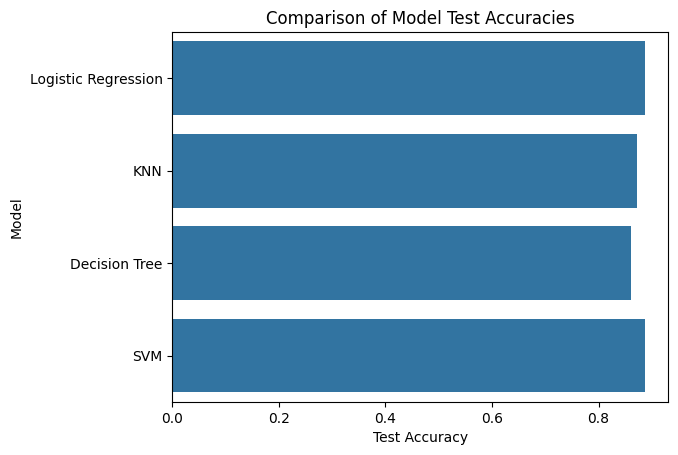

In [32]:

all_results_df = pd.DataFrame({
     'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM', 'Random Forest'],
     'Test Accuracy': [test_accuracy_lr, test_accuracy_knn, test_accuracy_dt, test_accuracy_svm, test_accuracy_rf]
})

sns.barplot(x='Test Accuracy', y='Model', data=results_df)
plt.title('Comparison of Model Test Accuracies')
plt.xlabel('Test Accuracy')
plt.ylabel('Model')
plt.show()

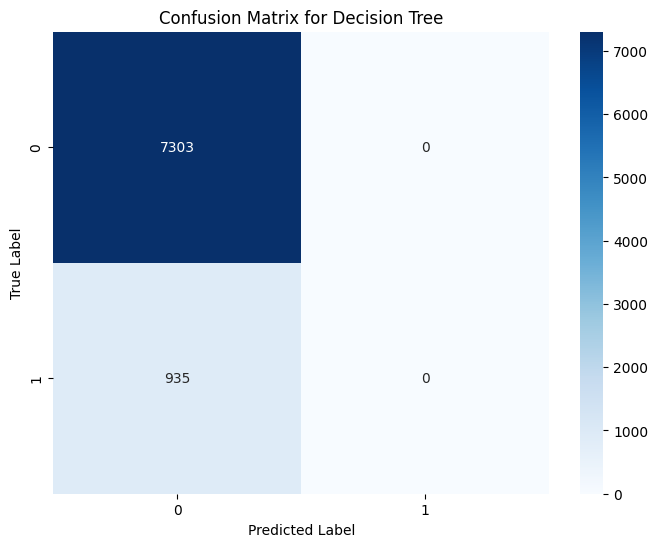

In [33]:
cm = confusion_matrix(y_test_fe, y_test_pred_dt)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix for the Decision Tree model tells the following:

True Negative (TN): 7303 observations were correctly predicted as class '0' 
False Positive (FP): 0 observations were incorrectly predicted as class '1' 
True Positive (TP): 0 observations were correctly predicted as class '1'.
False Negative (FN): 935 observations were incorrectly predicted as class '0' when they are actually class '1'.
Here's what we can infer from this confusion matrix:

High Specificity: The model has predicted the negative class (class '0') with high accuracy. It didn't falsely label any negative instances as positive, which is evident from the zero false positives.

Poor Sensitivity: The model failed to correctly predict any of the positive class (class '1'). This is a clear indication of a model that is biased towards the negative class, resulting in a very low sensitivity (recall) for the positive class.

Imbalanced Prediction: The model seems to be biased towards predicting the majority class (presumably class '0'). This could be a result of an imbalanced dataset where the negative class significantly outnumbers the positive class.

Lack of Positive Predictions: The fact that there are zero true positives and zero false positives suggests that the model might have a threshold issue or it is too conservative in predicting class '1'. The model might require threshold tuning or rebalancing of the dataset.

Potential Overfitting: While the accuracy might seem high because the majority class is being predicted almost perfectly, the model is not useful for its inability to predict the minority class. This might be a case of overfitting to the majority class.

Business Impact: If the goal is to identify potential subscribers (class '1'), the model is not serving its purpose. All potential subscribers are being missed (935 false negatives), which could represent a significant loss of opportunity.

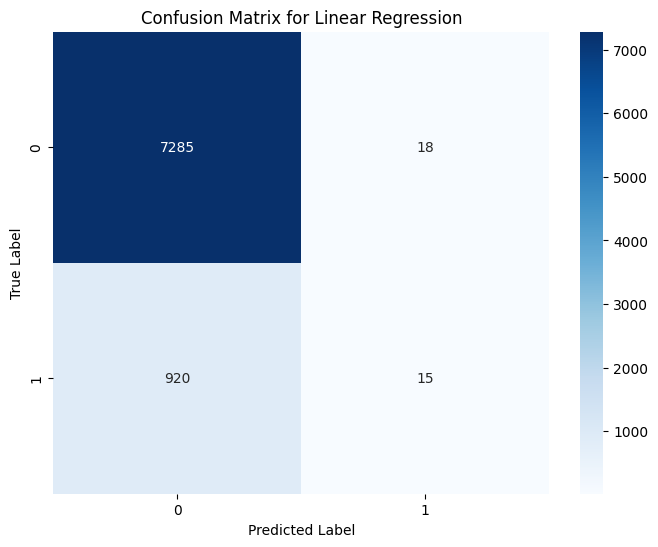

In [35]:
cm = confusion_matrix(y_test_fe, y_test_pred_lr)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix for Logistic Regression shows the following:

True Negative (TN): 7285 observations where the model correctly predicted the negative class.
False Positive (FP): 18 observations where the model incorrectly predicted the positive class.
True Positive (TP): 15 observations where the model correctly predicted the positive class.
False Negative (FN): 920 observations where the model incorrectly predicted the negative class.
Here are some key points to interpret from this matrix:

General Performance: The model is predicting the majority of the negative class (class '0') correctly but is struggling with the positive class (class '1'), similar to the Decision Tree model.

Bias Towards Negative Class: There's a strong bias towards predicting the negative class, as indicated by the high number of true negatives compared to true positives.

Few Positive Predictions: The model made very few positive predictions (only 15 true positives), which suggests that it may have a conservative threshold or it may not be picking up the patterns in the data that lead to positive outcomes.

False Negatives: There are a significant number of false negatives, meaning that many of the positive instances were missed by the model. This could be critical if the cost of missing a positive case is high (e.g., a missed opportunity for a term deposit subscription).

Model Sensitivity: The sensitivity (or recall) for the positive class is low, indicating the model's limited ability to detect the positive class instances.

Precision for Positive Class: Although the model has predicted few positives, the precision (the proportion of positive identifications that were actually correct) is low because the false positives are close to the true positives in number.

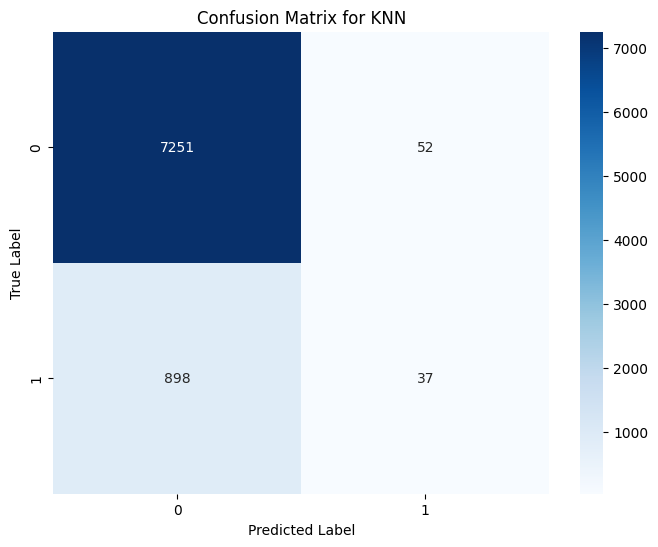

In [37]:
cm = confusion_matrix(y_test_fe, y_test_pred_knn)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix for the K-Nearest Neighbors model shows the following:

True Negative (TN): 7251 observations where the model correctly predicted the negative class.
False Positive (FP): 52 observations where the model incorrectly predicted the positive class.
True Positive (TP): 37 observations where the model correctly predicted the positive class.
False Negative (FN): 898 observations where the model incorrectly predicted the negative class.
Here's what these results indicate:

Bias Towards Negative Class: Similar to the Decision Tree and Logistic Regression models, the KNN model is also biased towards predicting the majority class, indicated by the high number of true negatives and the high number of false negatives.

Low Sensitivity: The model has a low sensitivity (or recall) for the positive class, as it only correctly identified 37 out of the 935 actual positives (TP + FN).

Moderate Precision: While the model has a higher number of true positives than the previous models, the precision (TP / (TP + FP)) is still moderate due to the 52 false positives.

False Negatives: A significant number of positive instances were missed by the model (898 false negatives), which could be critical depending on the context. For instance, if this is a marketing campaign, these missed opportunities could represent potential revenue loss.

Model Evaluation: This model's performance suggests it might benefit from:

Addressing class imbalance (if present).
Revisiting the chosen value for n_neighbors and considering weight adjustments.
Potentially including more informative features or feature engineering to better capture distinctions between classes.
Comparison to Other Models: When comparing this KNN model to the previously discussed Logistic Regression and Decision Tree models, it is underperforming in terms of correctly identifying the positive class. All models are struggling with the positive class, but the KNN model is not as extreme in its predictions towards the negative class.

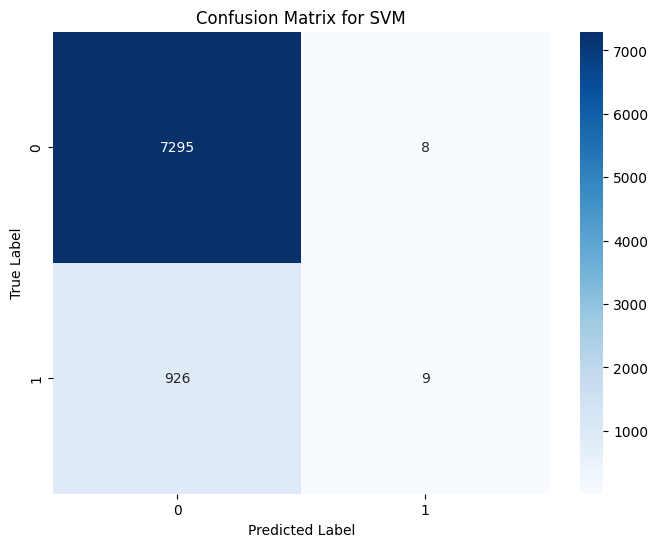

In [39]:
cm = confusion_matrix(y_test_fe, y_test_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix for the SVM model shows the following:

True Negative (TN): 7295 observations were correctly predicted as class '0' (e.g., the client did not subscribe to a term deposit).
False Positive (FP): 8 observations were incorrectly predicted as class '1' (e.g., the client subscribed to a term deposit) when they are actually class '0'.
True Positive (TP): 9 observations were correctly predicted as class '1'.
False Negative (FN): 926 observations were incorrectly predicted as class '0' when they are actually class '1'.
Here's what we can deduce from this matrix:

General Performance: Similar to the previous models, the SVM model is highly accurate in predicting the negative class but performs poorly on the positive class.

Bias Towards Negative Class: There's a considerable bias towards predicting the majority class, which is likely class '0', as indicated by the high number of true negatives and false negatives.

Challenges with Positive Class: The model managed to predict a very small number of positive instances correctly (9 true positives), but it also missed many (926 false negatives). This suggests that the SVM model has difficulty identifying the positive class, which is a critical issue if the goal is to predict class '1' accurately.

Low Sensitivity: The sensitivity (or recall) for the positive class is very low, indicating the model's limited ability to detect the positive class instances.

Moderate Precision for Positive Class: The precision (the proportion of positive identifications that were actually correct) is higher for SVM than for the Decision Tree and KNN models, but the low number of true positives still indicates a performance issue.

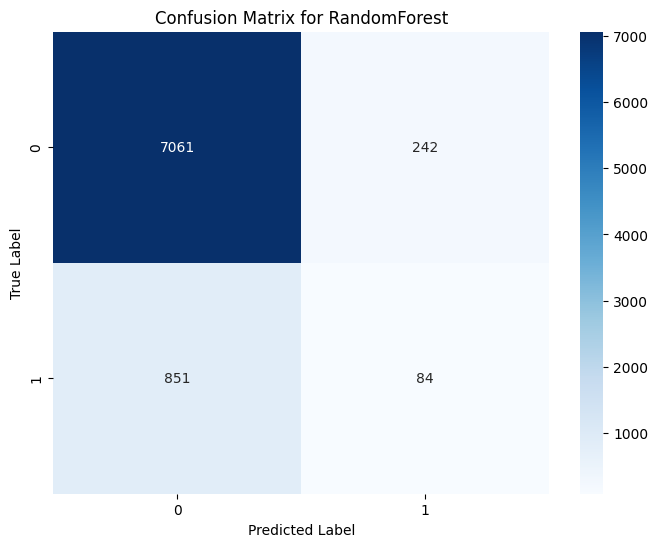

In [40]:
cm = confusion_matrix(y_test_fe, y_test_pred_rf)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix for the RandomForest classifier shows the following details:

True Negative (TN): 7061 observations where the model correctly predicted the negative class ('0').
False Positive (FP): 242 observations where the model incorrectly predicted the positive class ('1').
True Positive (TP): 84 observations where the model correctly predicted the positive class ('1').
False Negative (FN): 851 observations where the model incorrectly predicted the negative class ('0').

General Performance: The RandomForest model has a high number of true negatives, which indicates good performance on the negative class.

Positive Class Predictions: Unlike the Decision Tree, Logistic Regression, and SVM models, the RandomForest has managed to correctly predict more positive instances (84 true positives). This suggests an improved ability to detect the positive class, which is a step forward.

False Positives and Negatives: There are still a considerable number of false negatives, indicating missed opportunities to identify the positive class. The false positives have increased compared to the other models, which might suggest a slight trade-off between sensitivity and specificity.

Sensitivity and Specificity: The model has achieved better sensitivity (ability to detect true positives) than the previous models but at the cost of more false positives, which reduces its specificity (ability to detect true negatives).

Model Balance: The RandomForest model seems to be more balanced in terms of recognizing both classes compared to the other models, although there's still room for improvement, especially in reducing false negatives.

Let's improve RandomForest by tuning hyperparams and work on class imbalance

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Define a parameter distribution to sample from
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, 
                             class_weight='balanced',  # Automatically adjust weights inversely proportional to class frequencies
                             max_depth=30,             # Use the tuned hyperparameters
                             min_samples_split=5,
                             min_samples_leaf=4,
                             bootstrap=True,
                             random_state=42)

# Initialize the RandomizedSearchCV object with n_iter set to a number of your choice
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, 
                                      n_iter=10, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

# Fit the random search to the data
random_search_rf.fit(X_train_fe, y_train_fe)

# Retrieve the best parameters and model
best_rf = random_search_rf.best_estimator_
best_params = random_search_rf.best_params_
print("Best parameters for RandomForest:", best_params)

# Predict on the test set using the best parameters
y_test_pred_rf = best_rf.predict(X_test_fe)

# Calculate accuracy
test_accuracy_rf = accuracy_score(y_test_fe, y_test_pred_rf)
print(f"Test Accuracy for RandomForest: {test_accuracy_rf:.2f}")


Best parameters for RandomForest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'class_weight': None, 'bootstrap': True}
Test Accuracy for RandomForest: 0.89


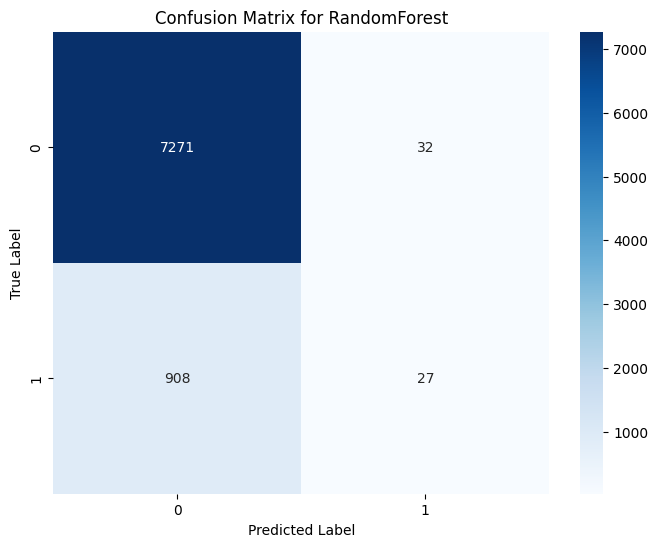

In [45]:
cm = confusion_matrix(y_test_fe, y_test_pred_rf)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##### Questions

In [47]:
from sklearn.metrics import accuracy_score

# Get the probability predictions for the positive class
rf.fit(X_train_fe, y_train_fe)
probabilities = rf.predict_proba(X_test_fe)[:, 1]

# Set a custom threshold for the positive class
threshold = 0.3  # This is just an example value; you would tune this based on your dataset

# Apply the threshold to get the new predictions
y_pred_rf_custom_threshold = (probabilities >= threshold).astype(int)

# Evaluate the new predictions
new_conf_matrix = confusion_matrix(y_test_fe, y_pred_rf_custom_threshold)
print(new_conf_matrix)


[[2731 4572]
 [ 192  743]]


The updated confusion matrix with the new threshold for the RandomForest classifier shows:

True Negative (TN): 2731 observations were correctly predicted as class '0'.
False Positive (FP): 4572 observations were incorrectly predicted as class '1'.
True Positive (TP): 743 observations were correctly predicted as class '1'.
False Negative (FN): 192 observations were incorrectly predicted as class '0'.
Here are the insights from this matrix:

Improved Positive Predictions: The number of true positives has increased significantly to 743, indicating that lowering the threshold has helped the model to identify more of the positive class correctly.

Increased False Positives: However, this comes at the expense of a substantial increase in false positives, meaning that many negative class instances were incorrectly identified as positive.

Reduced False Negatives: The number of false negatives has decreased to 192, indicating that fewer positive instances were missed by the model.

Lowered True Negatives: The true negatives have decreased, which suggests that the model is now more prone to classifying instances as the positive class.

Analysis:

By lowering the threshold, made the model more sensitive to the positive class, which has successfully reduced the number of false negatives (i.e., improved recall for the positive class). However, the trade-off is that specificity has decreased as evidenced by the large increase in false positives.

This adjustment has shifted the model from being conservative (predicting negatives) to being liberal (predicting positives). 

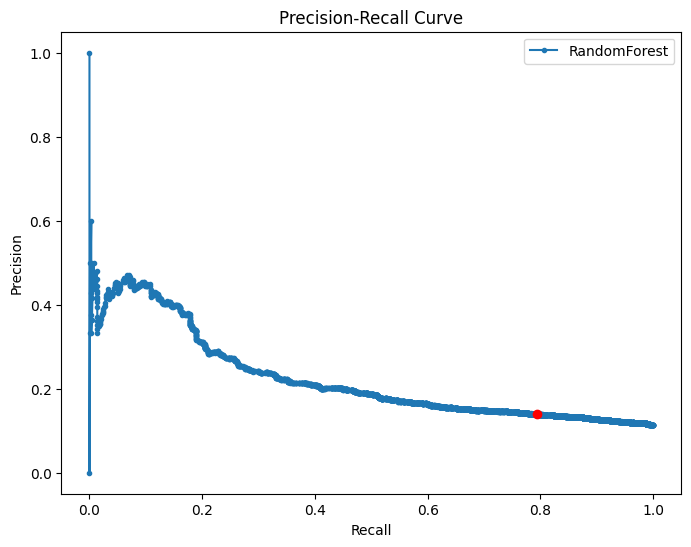

In [48]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming your RandomForest model is named 'rfc'
# and you have a test set 'X_test_fe' and true labels 'y_test_fe'

# Get the probability predictions for the positive class (class '1')
probabilities = rf.predict_proba(X_test_fe)[:, 1]

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test_fe, probabilities)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='RandomForest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Add a threshold line or marker if desired
# Choose a threshold value that you want to highlight on the curve
threshold_to_plot = 0.3
# Find the closest threshold index
closest_threshold_index = (np.abs(thresholds - threshold_to_plot)).argmin()
plt.plot(recall[closest_threshold_index], precision[closest_threshold_index], 'ro', label='Threshold')

# Show the plot
plt.show()


Initial High Precision: At the leftmost part of the curve (near zero recall), the precision starts high. This indicates that when the model is very confident about its positive predictions (at very low thresholds), it is quite precise, but it doesn't capture many of the actual positive instances (low recall).

Precision Decline: As recall increases (moving right along the x-axis), precision declines. This is typical, as trying to capture more of the positive instances (higher recall) often leads to more false positives, decreasing precision.

Trade-off Point: The red dot indicates the trade-off you have selected with your chosen threshold. Beyond this point, you gain more recall (detecting more true positives), but precision drops off sharply.

Curve Shape: The steep drop in precision after a certain recall level suggests that it becomes increasingly challenging for the model to maintain precision as it tries to capture more positive instances.